In [1]:
#This code ingests the provided dataset, throws out columns 5 and 6, and labels the columns.

loadData <- function(filepath = 'C:/Users/iakuznet/Desktop/the-fat-boys/data'){
	require(data.table)
	
	#The data is composed of 144 columns, with each 6 consecutive columns corresponding to 1 of 24 markers. Apparently column 5 and 6 of the data are unnecessary and should be thrown out.
	#List of fluorescent markers used
	markers <- c('Synap_1', 'Synap_2', 'VGlut1_1', 'VGlut1_2', 'VGlut2', 'VGlut3', 'PSD', 'Glur2', 'NDAR1', 'NR2B', 'GAD', 'VGAT', 'PV',
	'Gephyr', 'GABAR1', 'GABABR', 'CR1', '5HT1A', 'NOS', 'TH', 'VACht', 'Synapo', 'Tubuli', 'DAPI')
	
	#What columns 1-4 for each of the florescent markers coorespond to.
	labels <- c('Int_Bright','Local_Bright','Dist_COM','MOI')
	
	#Generate labels for each column
	col_labels <- c() 
	
	for (i in 1:length(markers)){
		for (j in 1:length(labels)){
			col_labels[(i - 1) * length(labels) + j] = paste(markers[i],"_",labels[j],sep = "")
		}
	}
	
	#Change to relevant location of file
	setwd(filepath)

	#Load in file using data.tables fread()
	data <- fread("synapsinR_7thA.tif.Pivots.txt.2011Features.txt")

	#Convert to dataframe
	data <- as.data.frame(data)

	#Remove columns 5 and 6 corresponding to each fluorescent marker
	good_ones <- c(1:dim(data)[2])
	dim(good_ones) <- c(6,dim(data)[2] / 6)
	good_ones <- good_ones[1:4,]
	dim(good_ones) <- c(4 * dim(good_ones)[2],1)
	data_cleaned <- data[,good_ones]
	
	#Label data
	colnames(data_cleaned) <- col_labels
	
	return(data_cleaned)
}

We load our dataset:

In [2]:
data <- loadData()

Loading required package: data.table
Warning message:
: package 'data.table' was built under R version 3.1.3

Read 1119299 rows and 144 (of 144) columns from 1.817 GB file in 00:05:23


In [3]:
keep_points <- fread("C:/Users/iakuznet/Desktop/the-fat-boys/filter_point")

In [4]:
#Subsamples 10000 rows from the original data set for easier analysis

subsampleRows <- function(data,samples = 10000,seed = 42){
	#Subsample some number of rows for further analysis. Set seed for reproducibility.
	set.seed(seed);rand_rows = sample(1:dim(data)[1],samples)
	subsample <- data[rand_rows,]
	return(subsample)
}

In [5]:
subsample <- subsampleRows(data)

In [6]:
subsample_keep <- subsampleRows(data[unlist(keep_points),])

In [7]:
#Scales each column of the input data frame by converting to Z scores and optionally log scaling the data

scaleData <- function(data,center = TRUE,scale = TRUE, log = TRUE){
	data_scaled <- scale(data, center = center,scale = scale)
    if(log){
        norm_0_1 <- function(x) {(x - min(x, na.rm=TRUE))/(max(x,na.rm=TRUE) - min(x, na.rm=TRUE))}
        data_scaled <- log(norm_0_1(data_scaled) + 1) / log(10)
    }
	return(data_scaled)
}

In [8]:
subsample <- scaleData(subsample, log = FALSE)
subsample_s <- scaleData(subsample)
subsample_keep <- scaleData(subsample_keep, log = FALSE)
subsample_s_keep <- scaleData(subsample_keep)

In [9]:
#For labeling

library(gplots)
library(colorRamps)

channel <- c('Synap_1','Synap_2','VGlut1_t1','VGlut1_t2','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI')
channel.type <- c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none')
nchannel <- length(channel)
nfeat <- ncol(data) / nchannel
fchannel <- as.numeric(factor(channel.type,
    levels= c("synap","ex.pre","ex.post","in.pre","in.post","in.pre.small","other","none")
    ))
ford <- order(fchannel)
Syncol <- c("purple","#197300","#5ed155","#990000","#cc0000","#ff9933","mediumblue","gold")
ccol <- Syncol[fchannel]


fname <- as.vector(sapply(channel,function(x) paste0(x,paste0("F",0:5))))
names(subsample) <- fname
names(subsample_s) <- fname
names(subsample_keep) <- fname
names(subsample_s_keep) <- fname
fcol <- rep(ccol, each=6)
mycol <- colorpanel(100, "purple", "black", "green")
mycol2 <- matlab.like(nchannel)
    


Warning message:
: package 'gplots' was built under R version 3.1.3
Attaching package: 'gplots'

The following object is masked from 'package:stats':

    lowess

Warning message:
: package 'colorRamps' was built under R version 3.1.3

In [10]:
#Use only f0

f0 <- seq(1,ncol(data),by=nfeat)
featF0s <- subset(subsample, select=f0)
flog <- subset(subsample_s, select=f0)

f0_keep <- seq(1,ncol(data),by=nfeat)
featF0s_keep <- subset(subsample_keep, select=f0)
flog_keep <- subset(subsample_s_keep, select=f0)

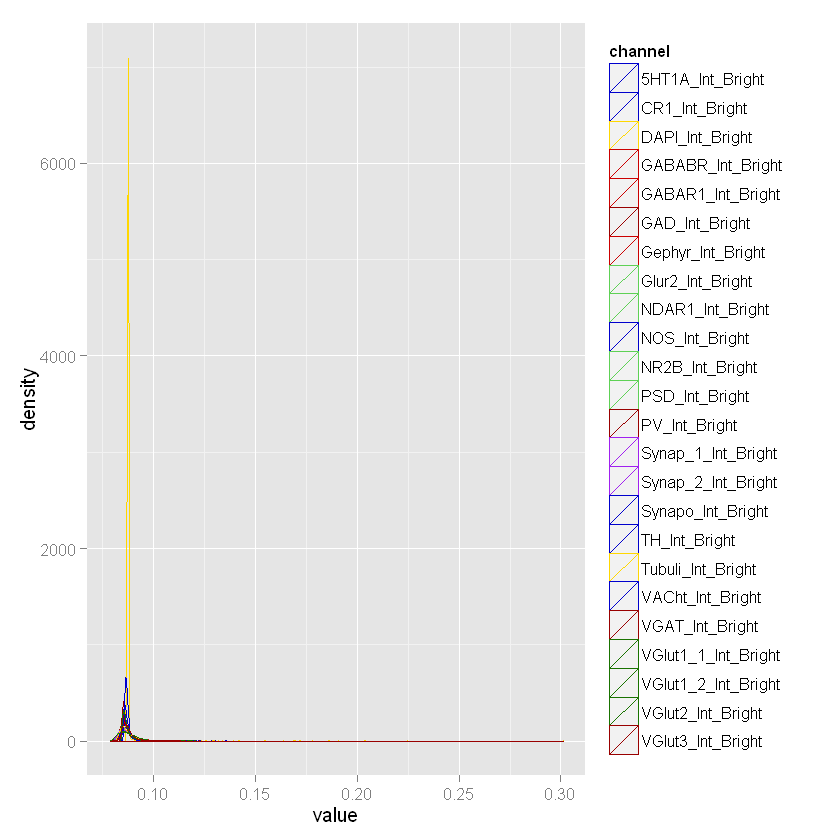

In [11]:
#Visualize the marginals with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog)

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + 
    scale_color_manual(values=ccol[order(unique(channel))]) +
    #scale_x_log10(limits=c(1e+03,1e+06), breaks=c(1e+03,5e+03,1e+04,5e+04,1e+05,5e+05,1e+06))+
    geom_density(aes(group=channel, colour=channel))

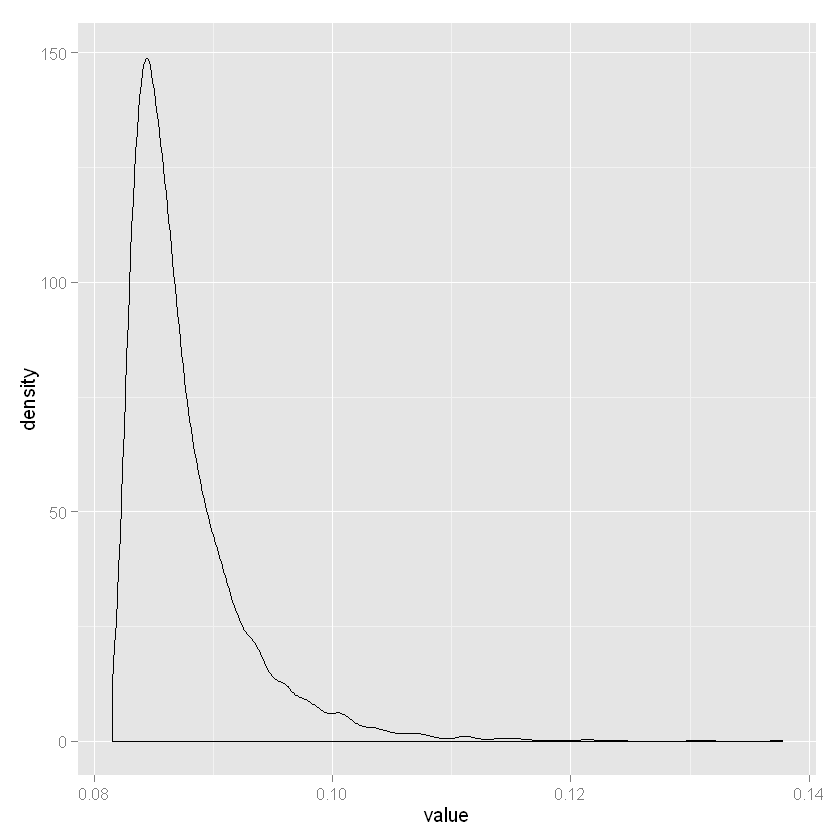

In [12]:
#Visualize only the synapsin marginal with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

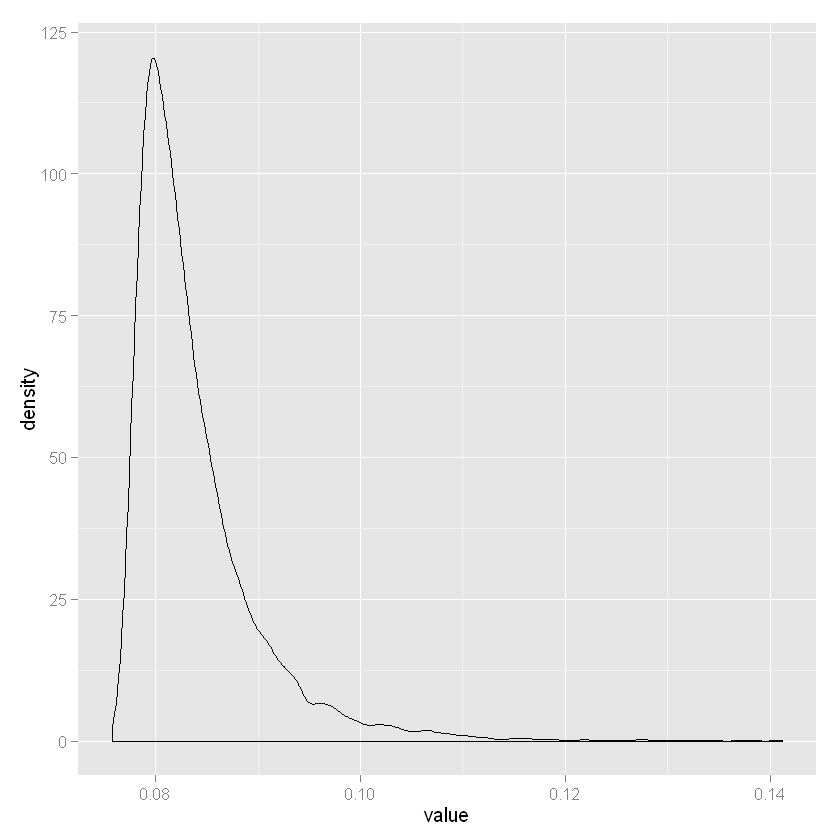

In [13]:
#Visualize only the synapsin marginal with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog_keep[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

In [14]:
keep_index <- which(featF0s[,1] > 1)
reject_index <- which(featF0s[,1] < 1) 
featF0s_rmdtc <-featF0s[keep_index,]
flog_rmdtc <- flog[keep_index,]
length(keep_index)

[1] 1242

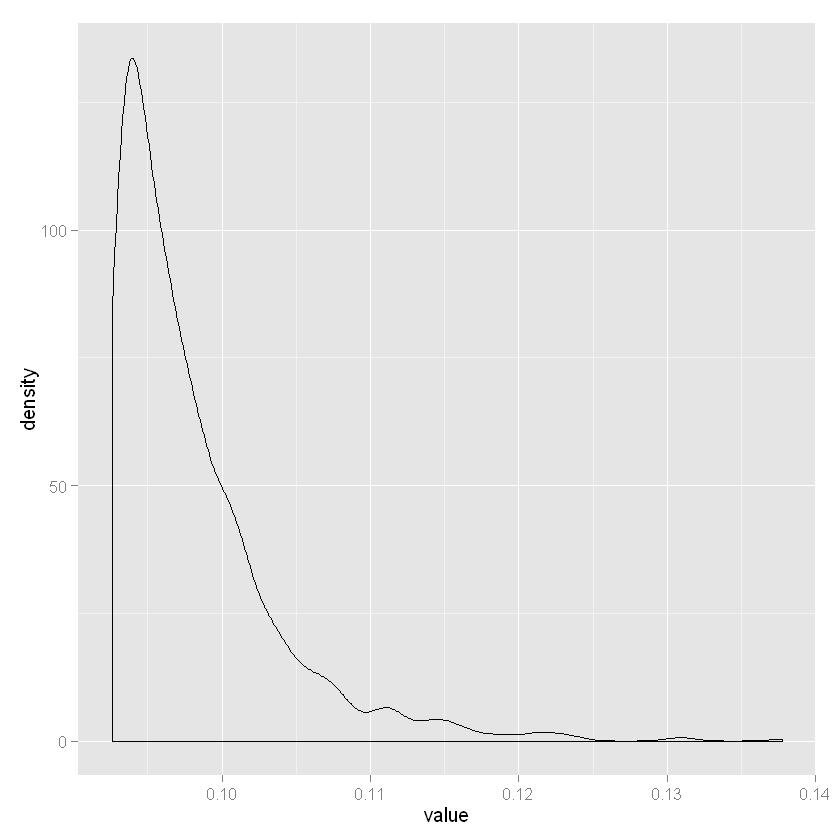

In [15]:
#Visualize only the synapsin marginal with log scaling
library(reshape)
library(ggplot2)

featKDE <- as.matrix(flog_rmdtc[,1])

df <- melt(featKDE)
names(df) <- c("ind","channel","value")
ggplot(df, aes(x=value)) + geom_density()

In [16]:
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)

K1 <- 12  ## Set the upperbound for k-means.

## Run kmeans on the scaled data
kvecF0 <- foreach(i = 1:K1) %dopar% {
    set.seed(2^13 - 1)
    kmeans(featF0s_rmdtc,centers=i)
}

## Run kmeans on the 
## log scale transformed data
kvecflog <- foreach(i = 1:K1) %dopar% {
    set.seed(2^13 - 1)
    kmeans(flog_rmdtc,centers=i)
}

Warning message:
: package 'doParallel' was built under R version 3.1.3Loading required package: foreach
Warning message:
: package 'foreach' was built under R version 3.1.3Loading required package: iterators
Warning message:
: package 'iterators' was built under R version 3.1.3Loading required package: parallel


 [1] "purple"     "purple"     "#197300"    "#197300"    "#5ed155"   
 [6] "#cc0000"    "#5ed155"    "#990000"    "gold"       "#990000"   
[11] "#990000"    "gold"       "#cc0000"    "#5ed155"    "mediumblue"
[16] "#5ed155"    "mediumblue" "#197300"    "mediumblue" "#990000"   
[21] "#cc0000"    "mediumblue" "mediumblue" "mediumblue"


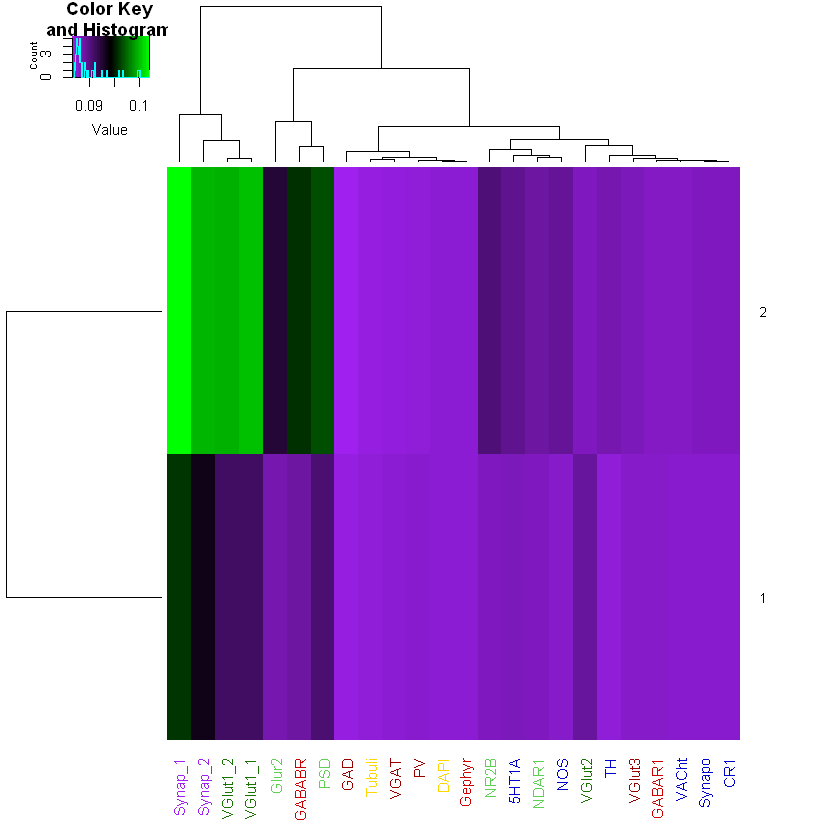

In [17]:
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc,by=list(lab=kvecflog[[2]]$cluster),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol,colCol=ccol,cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

 [1] "#cc0000"    "#990000"    "#990000"    "purple"     "purple"    
 [6] "#197300"    "#197300"    "#5ed155"    "#cc0000"    "#5ed155"   
[11] "mediumblue" "#990000"    "#cc0000"    "mediumblue" "#197300"   
[16] "#5ed155"    "mediumblue" "#5ed155"    "gold"       "mediumblue"
[21] "gold"       "mediumblue" "mediumblue" "#990000"   


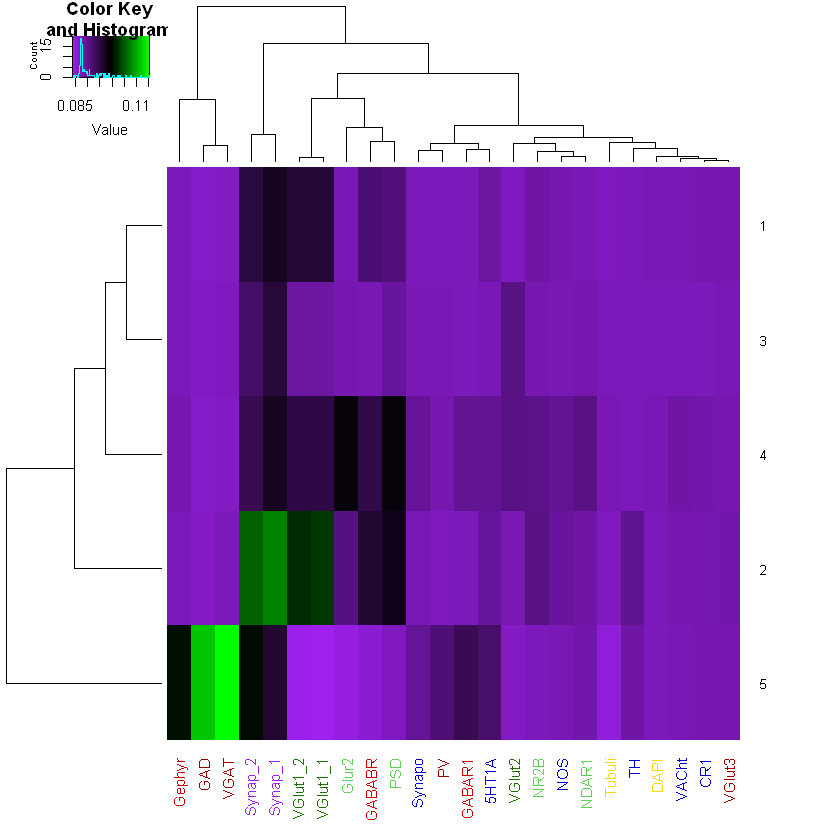

In [18]:
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc,by=list(lab=kvecflog[[5]]$cluster),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol,colCol=ccol,cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

In [19]:
library(cluster)
library(doParallel)
cl <- makeCluster(4)
registerDoParallel(cl)

K1 <- 12  ## Set the upperbound for pam.

## Run kmeans on the 
## log scale transformed data
pamvecflog <- foreach(i = 1:K1,.packages='cluster') %dopar% {
    set.seed(2^13 - 1)
    pam(flog_rmdtc,k = i, metric = "manhattan")
}

 [1] "purple"     "purple"     "#197300"    "#197300"    "#5ed155"   
 [6] "#cc0000"    "#5ed155"    "#5ed155"    "mediumblue" "#197300"   
[11] "mediumblue" "mediumblue" "mediumblue" "#5ed155"    "#990000"   
[16] "gold"       "#990000"    "#990000"    "mediumblue" "mediumblue"
[21] "#cc0000"    "#cc0000"    "gold"       "#990000"   


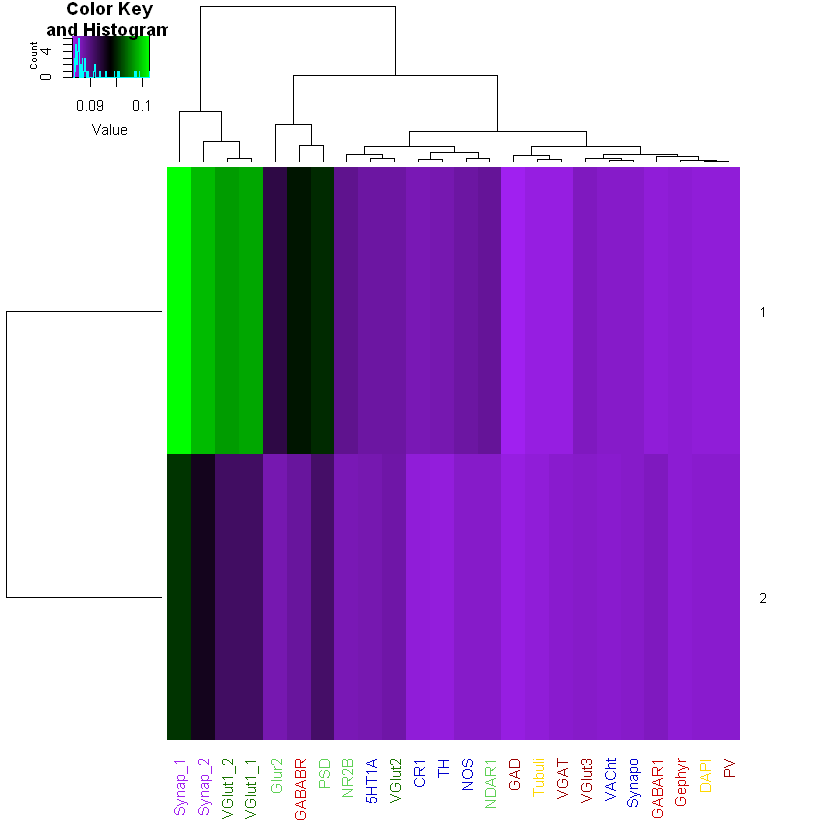

In [20]:
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc,by=list(lab=pamvecflog[[2]]$clustering),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol,colCol=ccol,cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

 [1] "#cc0000" "#5ed155" "#197300" "#197300" "#5ed155" "#197300" "#5ed155"
 [8] "#5ed155" "#990000" "#990000" "#cc0000" "#990000" "#990000" "#cc0000"


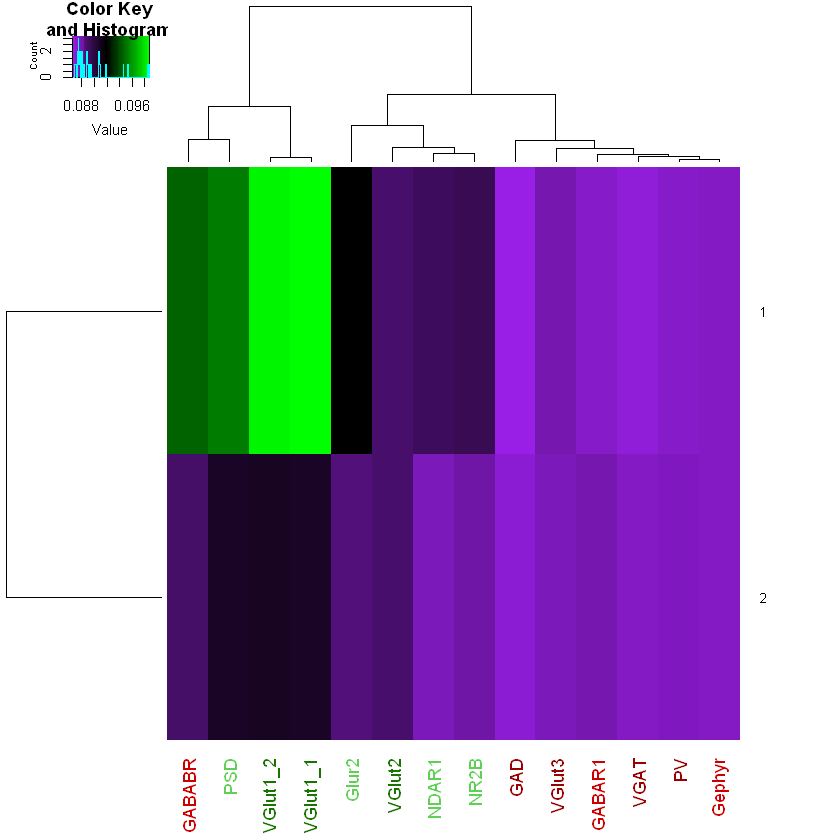

In [21]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc[,-c(1,2,17,18,19,20,21,22,23,24)],by=list(lab=pamvecflog[[2]]$clustering),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(1,2,17,18,19,20,21,22,23,24)],colCol=ccol[-c(1,2,17,18,19,20,21,22,23,24)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

 [1] "#197300" "#197300" "#197300" "#5ed155" "#cc0000" "#5ed155" "#990000"
 [8] "#990000" "#cc0000" "#990000" "#cc0000" "#990000" "#5ed155" "#5ed155"


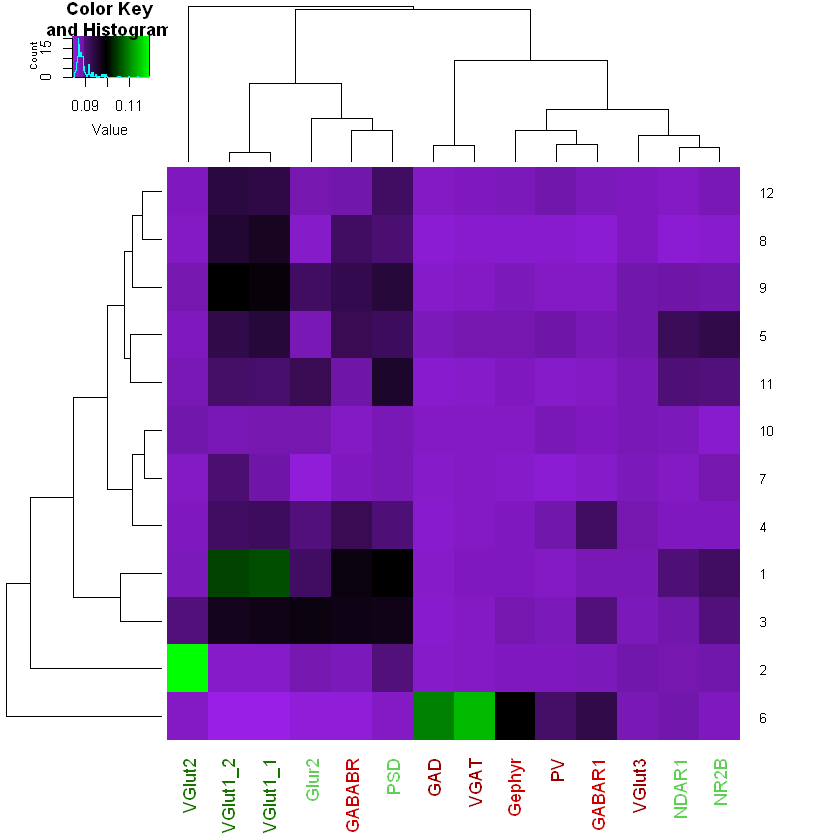

In [22]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- aggregate(flog_rmdtc[,-c(1,2,17,18,19,20,21,22,23,24)],by=list(lab=pamvecflog[[12]]$clustering),FUN=mean)
feat2 <- as.matrix(feat2[,-1])
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(1,2,17,18,19,20,21,22,23,24)],colCol=ccol[-c(1,2,17,18,19,20,21,22,23,24)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

Warning message:
: closing unused connection 7 (<-iakuznet-THINK:11114)Warning message:
: closing unused connection 6 (<-iakuznet-THINK:11114)Warning message:
: closing unused connection 5 (<-iakuznet-THINK:11114)Warning message:
: closing unused connection 4 (<-iakuznet-THINK:11114)

 [1] "#197300" "#197300" "#5ed155" "#cc0000" "#5ed155" "#5ed155" "#cc0000"
 [8] "#5ed155" "#990000" "#197300" "#990000" "#cc0000" "#990000" "#990000"


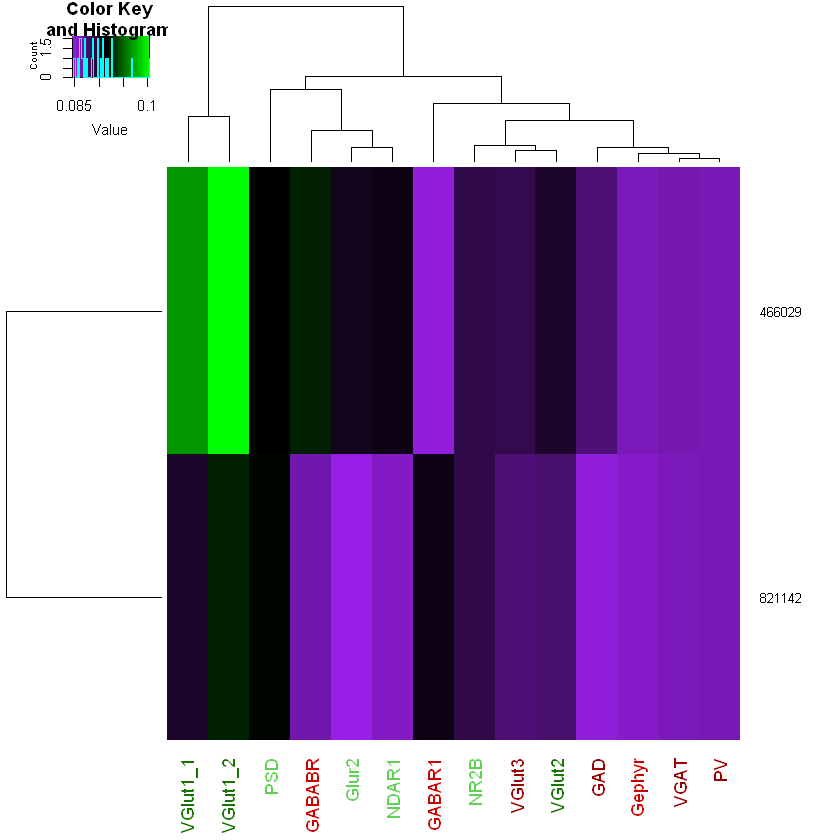

In [23]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- pamvecflog[[2]]$medoids[,-c(1,2,17,18,19,20,21,22,23,24)]
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(1,2,17,18,19,20,21,22,23,24)],colCol=ccol[-c(1,2,17,18,19,20,21,22,23,24)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

Throw out VGglut1_2:

 [1] "#5ed155" "#197300" "#cc0000" "#5ed155" "#5ed155" "#cc0000" "#5ed155"
 [8] "#990000" "#197300" "#990000" "#cc0000" "#990000" "#990000"


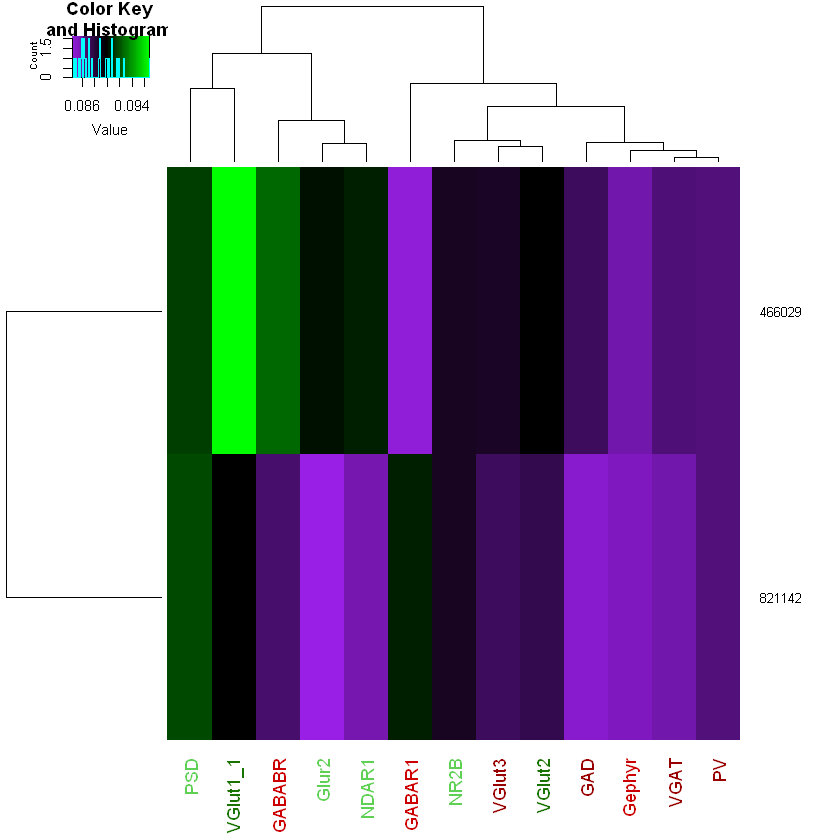

In [24]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- pamvecflog[[2]]$medoids[,-c(1,2,4,17,18,19,20,21,22,23,24)]
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(1,2,4,17,18,19,20,21,22,23,24)],colCol=ccol[-c(1,2,4,17,18,19,20,21,22,23,24)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

Throw out PSD:

 [1] "#990000" "#cc0000" "#cc0000" "#990000" "#990000" "#197300" "#197300"
 [8] "#990000" "#5ed155" "#5ed155" "#5ed155" "#cc0000"


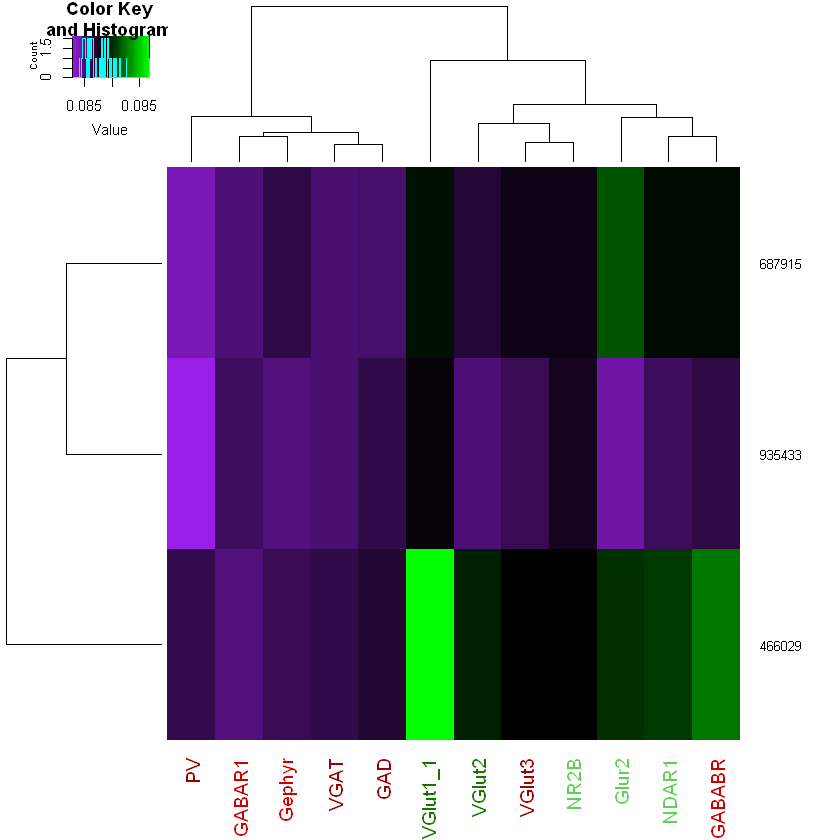

In [25]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- pamvecflog[[3]]$medoids[,-c(1,2,4,7,17,18,19,20,21,22,23,24)]
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(1,2,4,7,17,18,19,20,21,22,23,24)],colCol=ccol[-c(1,2,4,7,17,18,19,20,21,22,23,24)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

 [1] "#197300"    "purple"     "#5ed155"    "#cc0000"    "#5ed155"   
 [6] "mediumblue" "#5ed155"    "#cc0000"    "#990000"    "#197300"   
[11] "mediumblue" "#5ed155"    "#990000"    "mediumblue" "gold"      
[16] "mediumblue" "gold"       "mediumblue" "#cc0000"    "#990000"   
[21] "#990000"    "mediumblue"


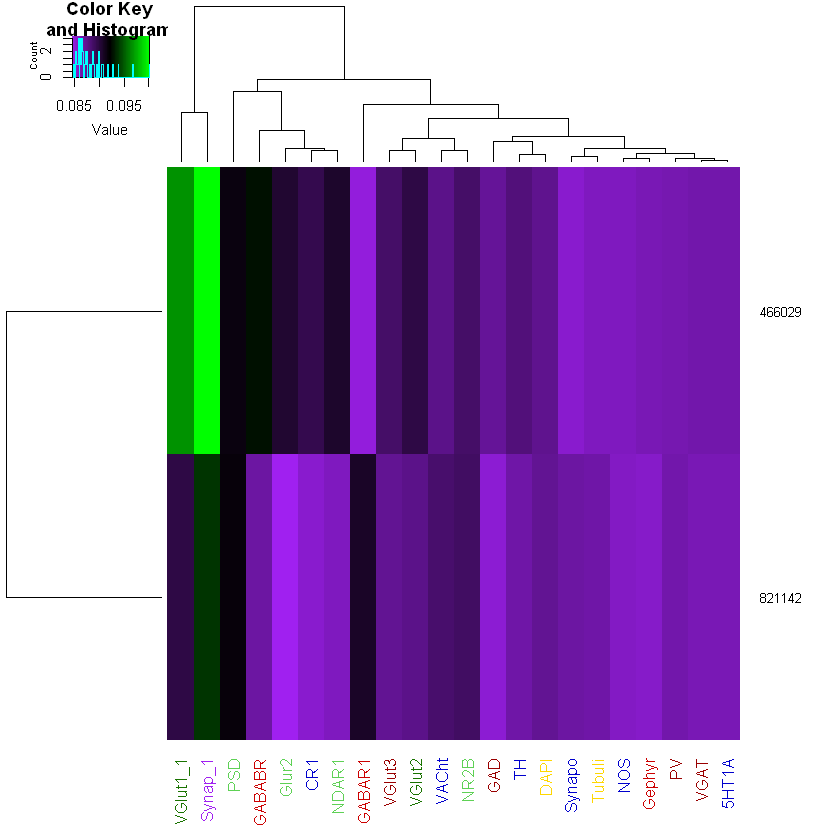

In [26]:
#Throw out everything now excitatory or inhibitory. As we have c('synap','synap','ex.pre','ex.pre','ex.pre','in.pre', 
#'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre','in.pre','in.post','in.post','in.post','other','other',
#'other','other','other','other','none','none') we throw out 1,2,17,18,19,20,21,22,23,24. Inhibitory is 6,11,12,13,14,15,15. 
#Excitatory is 3,4,5,7,8,9,10
## Formatting data for heatmap
feat2 <- pamvecflog[[2]]$medoids[,-c(2,4)]
colnames(feat2) <-  gsub('_Int_Bright','',colnames(feat2))

ford <- order(fchannel)
heatmap.2(as.matrix(feat2), trace="none",col=mycol[-c(2,4)],colCol=ccol[-c(2,4)],cexRow=0.8, keysize=1,symkey=FALSE,symbreaks=FALSE,scale="none", srtCol=90) # 

In [27]:
library(fossil)
result <- pamvecflog[[2]]$medoids[,-c(1,2,4,7,17,18,19,20,21,22,23,24)]
inh <- c(6,11,12,13,14,15,16) 
exc <- c(3,5,8,9,10)
kres <- kmeans(t(result), centers = 2,iter.max = 20)
kres$cluster
actual <- c(1:16)
actual[exc] <- 2
actual[inh] <- 1
actual <- actual[-c(1,2,4,7)]
actual

adj.rand.index(kres$cluster,actual)

Warning message:
: package 'fossil' was built under R version 3.1.3Loading required package: sp
Warning message:
: package 'sp' was built under R version 3.1.3Loading required package: maps
Warning message:
: package 'maps' was built under R version 3.1.3
 # ATTENTION: maps v3.0 has an updated 'world' map.        #
 # Many country borders and names have changed since 1990. #
 # Type '?world' or 'news(package="maps")'. See README_v3. #



Attaching package: 'maps'

The following object is masked from 'package:cluster':

    votes.repub

Loading required package: shapefiles
Warning message:
: package 'shapefiles' was built under R version 3.1.3Loading required package: foreign

Attaching package: 'shapefiles'

The following objects are masked from 'package:foreign':

    read.dbf, write.dbf



VGlut1_1_Int_Bright   VGlut2_Int_Bright   VGlut3_Int_Bright    Glur2_Int_Bright 
                  1                   1                   2                   1 
   NDAR1_Int_Bright     NR2B_Int_Bright      GAD_Int_Bright     VGAT_Int_Bright 
                  1                   2                   2                   2 
      PV_Int_Bright   Gephyr_Int_Bright   GABAR1_Int_Bright   GABABR_Int_Bright 
                  2                   2                   2                   1

[1] 2 2 1 2 2 2 1 1 1 1 1 1

[1] 0.3917051

In [28]:

result <- pamvecflog[[2]]$medoids[,-c(1,2,4,7)]
inh <- c(6,11,12,13,14,15,16) 
exc <- c(3,5,8,9,10)
kres <- kmeans(t(result), centers = 3,iter.max = 20)
kres$cluster
actual <- c(1:24)
actual[exc] <- 2
actual[inh] <- 1
actual[17:24] <- 3
actual <- actual[-c(1,2,4,7)]
actual

adj.rand.index(kres$cluster,actual)

VGlut1_1_Int_Bright   VGlut2_Int_Bright   VGlut3_Int_Bright    Glur2_Int_Bright 
                  2                   1                   1                   1 
   NDAR1_Int_Bright     NR2B_Int_Bright      GAD_Int_Bright     VGAT_Int_Bright 
                  1                   1                   3                   3 
      PV_Int_Bright   Gephyr_Int_Bright   GABAR1_Int_Bright   GABABR_Int_Bright 
                  3                   3                   3                   1 
     CR1_Int_Bright    5HT1A_Int_Bright      NOS_Int_Bright       TH_Int_Bright 
                  1                   3                   3                   3 
   VACht_Int_Bright   Synapo_Int_Bright   Tubuli_Int_Bright     DAPI_Int_Bright 
                  3                   3                   3                   3

[1] 2 2 1 2 2 2 1 1 1 1 1 1 3 3 3 3 3 3 3 3

[1] 0.2388692

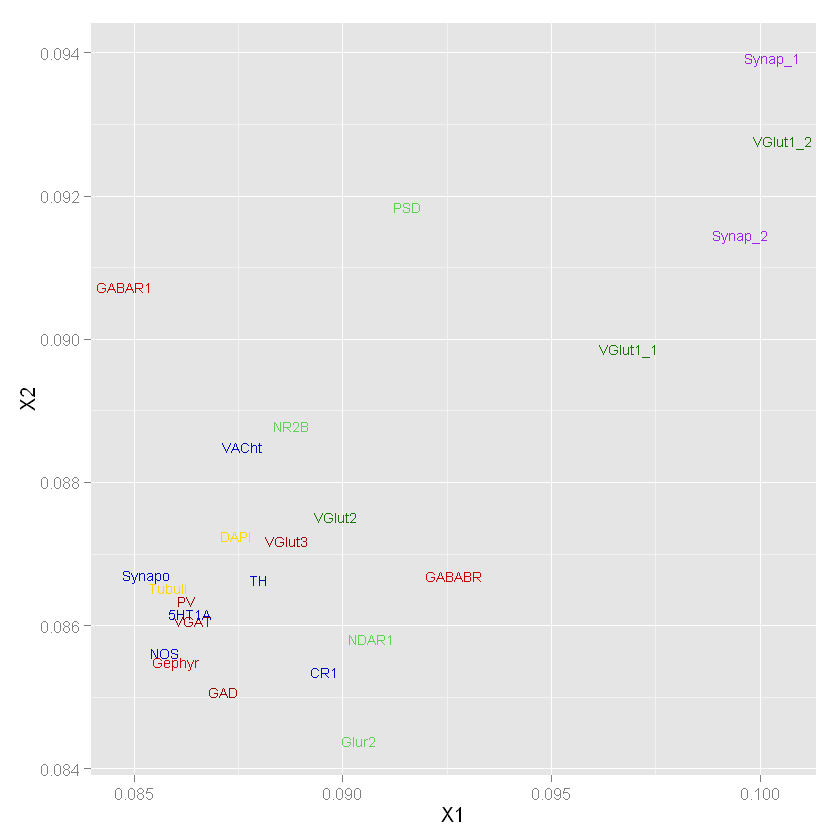

In [69]:
df <- as.data.frame(t(pamvecflog[[2]]$medoids))

rownames(df) <- gsub('_Int_Bright','',rownames(df))
df <- cbind(df,as.data.frame(rownames(df)))
colnames(df) <- c('X1','X2','X3')

p1 <- ggplot(df,aes(X1,X2,color = X3, label = X3)) + scale_color_manual(values=ccol[order(unique(channel))]) + geom_text(check_overlap = TRUE, size = 3)
p1 <- p1 + theme(legend.position = "none")
p1

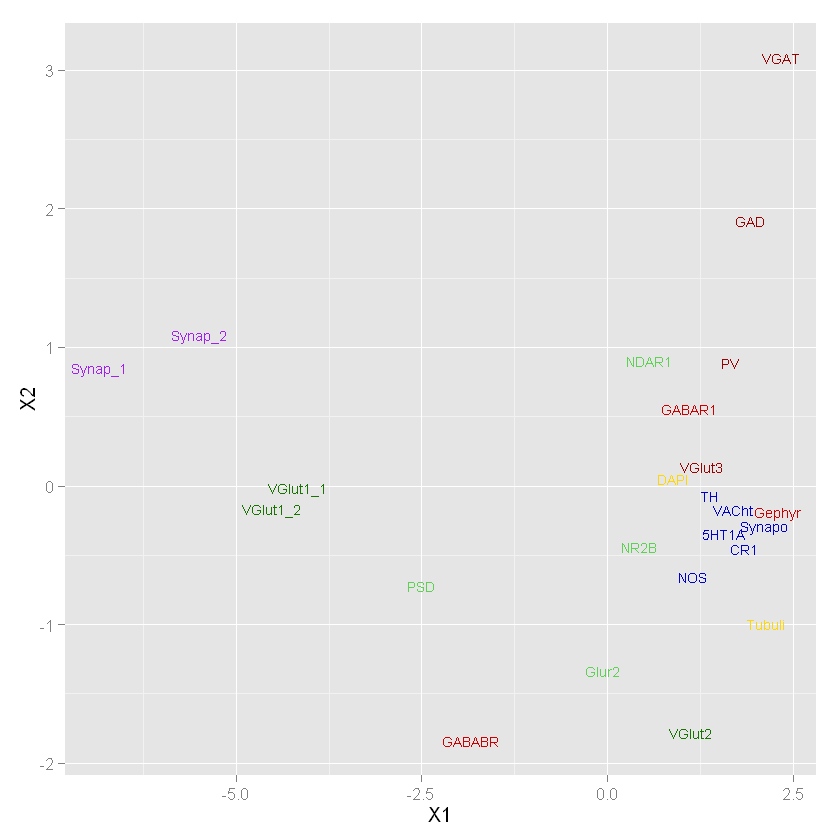

In [70]:
df <- as.data.frame(t(pamvecflog[[12]]$medoids))
res <- prcomp(df, center = TRUE, scale = TRUE)
df <- res$x[,1:2]

rownames(df) <- gsub('_Int_Bright','',rownames(df))
df <- cbind(df,as.data.frame(rownames(df)))
colnames(df) <- c('X1','X2','X3')

p2 <- ggplot(df,aes(X1,X2,color = X3, label = X3)) + scale_color_manual(values=ccol[order(unique(channel))]) + geom_text(check_overlap = TRUE, size = 3)
p2 <- p2 + theme(legend.position = "none")
p2